## Swiss-Prot (Putative) Data Formatting
This file takes data regarding kinase-protein interactions from the Swiss-Prot database (accessed through the Kinase-Phos database) and converts the data regarding experimental interactions into the .gmt format. The data was retrieved from the Kinase-Phos database on Mon, Jun 19 2017 at 11:13:24. This data will be added to enhance the KEA2 database and will be suitable formatted for use by ENRICHR and X2K. the citation for the data used in this script is "Huang, H.-D., Lee, T.-Y., Tzeng, S.-W., & Horng, J.-T. (2005). KinasePhos: a web tool for identifying protein kinase-specific phosphorylation sites. Nucleic Acids Research, 33(Web Server issue), W226–W229." and can also be found on the corresponding gh.pages website.

## Import packages necessary for following program

In [1]:
%run /home/maayanlab/Desktop/Projects/KEA3/Scripts/init.ipy

## Create a dataframe form a file containing Swiss-Prot Putative data

In [2]:
#Read in dataframe (including empty columns pd.read_table() sees)
s = pd.read_table('~/Desktop/Projects/KEA3/Swiss_phos_putative(1).tab',
                      names = ['Substrate', 'Pos', 'kinase_type', 'sequence',
                               ''])

#Filter out empty columns and remove unnecessary
#'sequence' and 'Pos' column
swiss = s[['Substrate', 'kinase_type']]

swiss.drop_duplicates(inplace = True)

#View dataframe
swiss.head()

/home/maayanlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Substrate,kinase_type
0,1433B_BOVIN,Phosphoserine (By similarity)
1,1433B_HUMAN,Phosphoserine (By similarity)
2,1433B_MOUSE,Phosphoserine (By similarity)
3,1433B_RAT,Phosphoserine (By similarity)
4,1433Z_BOVIN,Phosphoserine (By similarity)


## Filter by organism (Human and Mouse)

In [3]:
#Create new column 'Organism'
swiss.insert(0, "Organism", "None")

#Separate species and substrate names from each other
#Store substrate name alone and organism alone in separate  column
for index, string in swiss.Substrate.iteritems():
    swiss.Organism[index] = string.split("_", 2)[1]
    swiss.Substrate[index] = string.split("_", 2)[0]

/home/maayanlab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#Replace common names for human and mouse with scientific names
swiss.replace('HUMAN', 'Homo sapiens', inplace = True)
swiss.replace('MOUSE', 'Mus musculus', inplace = True)

/home/maayanlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/maayanlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
#View dataframe
swiss.head()

,Organism,Substrate,kinase_type
0,BOVIN,1433B,Phosphoserine (By similarity)
1,Homo sapiens,1433B,Phosphoserine (By similarity)
2,Mus musculus,1433B,Phosphoserine (By similarity)
3,RAT,1433B,Phosphoserine (By similarity)
4,BOVIN,1433Z,Phosphoserine (By similarity)


In [6]:
#Filter indices only for substrates/kinases pertaining to human and mouse data
indices = [index for index, rowData in swiss.iterrows() 
           if rowData['Organism'] in ['Homo sapiens', 
                                      'Mus musculus']]
#Create new dataframe using these indices
swiss_filter = swiss.loc[indices]

#View dataframe
swiss_filter.head()

,Organism,Substrate,kinase_type
1,Homo sapiens,1433B,Phosphoserine (By similarity)
2,Mus musculus,1433B,Phosphoserine (By similarity)
5,Homo sapiens,1433Z,Phosphoserine (By similarity)
6,Mus musculus,1433Z,Phosphoserine (By similarity)
9,Homo sapiens,3BP5,Phosphoserine (by MAPK12 and MAPK9) (Bysimilar...


## Filter 'Kinase_type' to Retrieve Kinases

In [7]:
#Insert new column, which will represent the 'kinase' for each substrate
swiss_filter.insert(0, 'kinase', 'None')

In [8]:
#Split string of 'kinase_type' to retrieve only individual kinase gene symbol
for index, string in swiss_filter.kinase_type.iteritems():
    s = string
    if "(" in s:
        s = string.split("(", 2)[1]
    if " " in s:
        s = s.split(" ", 2)[1]
    if ')' in s:
        s = s.split(")", 1)
        swiss_filter.kinase[index] = s[0]


#For rows without a specific kinase gene symbol, replace with NaN
swiss_filter.replace(['Potential', 'similarity', 'None', 'partial',
                      'Phosphotyrosine', 'Phosphoserine', 'Phosphothreonine'],
                     np.nan, inplace = True)

#Drop all NaNs from the dataframe
swiss_filter.dropna(inplace = True)

#Drop 'kinase_type' column since it is no lnger needed
swiss_filter.drop('kinase_type', axis = 1, inplace = True)

#View dataframe
swiss_filter.head()

,kinase,Organism,Substrate
10,MAPK12,Homo sapiens,3BP5
12,MAPK12,Mus musculus,3BP5
42,CK2,Mus musculus,A4
43,CK1,Mus musculus,A4
68,autocatalysis,Homo sapiens,AAKB1


## Combine 'Kinase' and 'Organism' Column and Create New Dataframe

In [9]:
#Create new column 'kinase_organism' joining together 'kinase' and 'Organism' columns
swiss_filter['Kinase_organism'] = ['_'.join([rowData['kinase'], rowData['Organism']]) 
                                            for index, rowData in 
                                            swiss_filter.iterrows()]

#Create new dataframe 'df_sig' and drop columns no longer needed
df_sig = swiss_filter.drop('kinase', axis = 1)
df_sig.drop('Organism', axis = 1, inplace = True)

#Drop any duplicates in the dataframe
df_sig.drop_duplicates(inplace = True)
df = df_sig.drop_duplicates()

#View dataframe
df.head()

,Substrate,Kinase_organism
10,3BP5,MAPK12_Homo sapiens
12,3BP5,MAPK12_Mus musculus
42,A4,CK2_Mus musculus
43,A4,CK1_Mus musculus
68,AAKB1,autocatalysis_Homo sapiens


## Create File of 'df' for Later Data Aggregation

In [10]:
#Create dictionary with index numbers as keys
d = dict([(key, '') for key in df.index])

# loop through rows with iterrows()
for index, rowData in df.iterrows():
    line = ('\t'.join(rowData))
    d[index] = line
    
#Transfer tab-separated info into a new txt file
with open('Uncondensed_SwissProt_Put.txt', 'w') as openfile:
    for index in d:
        openfile.write(str(d[index]) + '\n')

## Set Index to 'Kinase_Organism' and Aggregate Kinase Targets

In [11]:
#Set index to 'Kinase_organism'
df.set_index('Kinase_organism')

#Group kinases in dataframe 'kin'
#Aggregate data in 'kin' according to kinase groups
kin = df.groupby('Kinase_organism').agg(lambda x: tuple(x))

#Create a new column 'Swiss-Prot Exp.' as description of data
kin.insert(0, 'Description', 'Swiss-Prot Put.')

#Visualize Data
kin.head()

,Description,Substrate
Kinase_organism,,
ABL1_Homo sapiens,Swiss-Prot Put.,"(CDK5,)"
ABL2_Mus musculus,Swiss-Prot Put.,"(SIVA,)"
ABL_Homo sapiens,Swiss-Prot Put.,"(DCX, PLS4)"
ABL_Mus musculus,Swiss-Prot Put.,"(DCX, PLS1)"
AMPK_Homo sapiens,Swiss-Prot Put.,"(LIPS,)"


# Exploratory Data Analysis

## Calculate Number of Protein targets for each kinase
Create a new column with the number of substrates related to each kinase, and sort the dataframe by this column

In [12]:
# Create column representing counts of protein targets per kinase
kin['kinase_substrate_num'] = [len(lst) for kinase, lst in kin['Substrate'].iteritems()]

# Sort kinases from max to min according to number of protein targets each has
kin.sort_values(by = ['kinase_substrate_num'], ascending= False, inplace=True)

# View dataframe
kin.head()

,Description,Substrate,kinase_substrate_num
Kinase_organism,,,
autocatalysis_Mus musculus,Swiss-Prot Put.,"(AAKB1, ABL1, ALK, BCKD, BLK, BMX, BTK, CSK, D...",101
autocatalysis_Homo sapiens,Swiss-Prot Put.,"(AAKB1, AAPK1, AAPK2, ABL1, ALK, BCKD, BLK, BM...",100
PKA_Homo sapiens,Swiss-Prot Put.,"(ACLY, ADA1A, ADRB1, ADRB2, AP2B, AP2C, AT12A,...",58
PKA_Mus musculus,Swiss-Prot Put.,"(ABCA1, ACLY, ADA1A, ADDA, ADDB, ADRB1, ADRB2,...",55
PKC_Homo sapiens,Swiss-Prot Put.,"(ADDG, AT1A1, AT2B2, AT2B3, AT2B4, BCL2, CSTF2...",29


## Create Histogram to Display Distribution of Number of Protein Targets

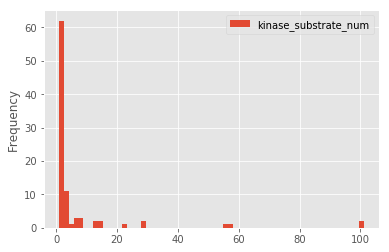

In [13]:
# Create histogram displaying the distribution of the number
#targets per kinase
kin.plot.hist(by = 'kinase_substrate_num', bins = 63)

#Show histogram
plt.show()

## Filter Dataframe by the Number of Substrates for each Kinase
If thekinase has fewer than five targets, this kinase will not be included in the final .gmt file. Instead, its information will be carried over into a .sig file.

In [14]:
df_sig.head()

,Substrate,Kinase_organism
10,3BP5,MAPK12_Homo sapiens
12,3BP5,MAPK12_Mus musculus
42,A4,CK2_Mus musculus
43,A4,CK1_Mus musculus
68,AAKB1,autocatalysis_Homo sapiens


In [15]:
#Create list of indexes(kinase names) for kinases with fewer than five substrates
sig_key = [index for index, rowData in kin.kinase_substrate_num.iteritems() if rowData < 5 ]

#Set indices for dataframe 'kin' of kinases with five or more substrates
indices = [index for index in kin.index if index not in sig_key]

#Create dataframe of only kinases with five or more substrates
sig = df_sig.set_index('Kinase_organism').loc[indices]

#Reset index of new dataframe
sig.reset_index(inplace = True)

#Rename columns of this dataframe to match .sig format
colnames = ['Source', 'Substrate']
sig.columns = colnames

In [16]:
#Insert first four columns for .sig file format (NaNs)
sig.insert(1, 'NA-1', str(np.nan))
sig.insert(2, 'NA-2', str(np.nan))
sig.insert(3, 'NA-3', str(np.nan))
sig.insert(4, 'NA-4', str(np.nan))

#Insert column corresponding to sign (with '?' because it is unknown)
sig.insert(6, 'Sign', '?')

#Insert column specifying interaction type as phosphorylation
sig.insert(7, 'Interaction', 'Phosphorylation')

#Insert 'Reference' column as the citation of NetworKIN paper, as no other citation
#was provided
#Insert column specifying interaction type as phosphorylation
sig.insert(8, 'Reference', "Huang, H.-D., Lee, T.-Y., Tzeng, S.-W., & Horng, J.-T. (2005). KinasePhos: a web tool for identifying protein kinase-specific phosphorylation sites. Nucleic Acids Research, 33(Web Server issue), W226–W229.") 
#View dataframe
sig.head()

,Source,NA-1,NA-2,NA-3,NA-4,Substrate,Sign,Interaction,Reference
0,autocatalysis_Mus musculus,nan,nan,nan,nan,AAKB1,?,Phosphorylation,"Huang, H.-D., Lee, T.-Y., Tzeng, S.-W., & Horn..."
1,autocatalysis_Mus musculus,nan,nan,nan,nan,ABL1,?,Phosphorylation,"Huang, H.-D., Lee, T.-Y., Tzeng, S.-W., & Horn..."
2,autocatalysis_Mus musculus,nan,nan,nan,nan,ALK,?,Phosphorylation,"Huang, H.-D., Lee, T.-Y., Tzeng, S.-W., & Horn..."
3,autocatalysis_Mus musculus,nan,nan,nan,nan,BCKD,?,Phosphorylation,"Huang, H.-D., Lee, T.-Y., Tzeng, S.-W., & Horn..."
4,autocatalysis_Mus musculus,nan,nan,nan,nan,BLK,?,Phosphorylation,"Huang, H.-D., Lee, T.-Y., Tzeng, S.-W., & Horn..."


In [17]:
#Remove kinases with fewer than five substrates in 'kin'
kin = kin.loc[indices]

## Create .Sig File

In [18]:
#Create dictionary 'sigd' with index numbers as keys
sigd = dict([(key, '') for key in sig.index])

# loop through rows with iterrows()
for index, rowData in sig.iterrows():
    line = ('\t'.join(rowData))
    sigd[index] = line
    
#Transfer tab-separated info into a new txt file
#Make sure to include in ReadMe corresponding column names
with open('SwissProtPutsig.txt', 'w') as openfile:
    for index in sigd:
        openfile.write(str(sigd[index]) + '\n')

# Creation of Final .GMT File

## Create dictionary of Tab-Separated rows of the Dataframe

In [19]:
#Reset index of the dataframe
kin.reset_index(inplace = True)

#create column 'acc_merged' in which all 'acc' elements are joined by a \t symbol
kin['target_merged'] = ['\t'.join(x) for x in kin['Substrate']]

#drop the now-unneccesary column 'Substrates'
kin.drop('Substrate', axis=1, inplace = True)

#also drop the data-exploratory column 'kinase_substrate_num'
kin.drop('kinase_substrate_num', axis=1, inplace = True)

#View dataframe
kin.head()

,Kinase_organism,Description,target_merged
0,autocatalysis_Mus musculus,Swiss-Prot Put.,AAKB1\tABL1\tALK\tBCKD\tBLK\tBMX\tBTK\tCSK\tDA...
1,autocatalysis_Homo sapiens,Swiss-Prot Put.,AAKB1\tAAPK1\tAAPK2\tABL1\tALK\tBCKD\tBLK\tBMX...
2,PKA_Homo sapiens,Swiss-Prot Put.,ACLY\tADA1A\tADRB1\tADRB2\tAP2B\tAP2C\tAT12A\t...
3,PKA_Mus musculus,Swiss-Prot Put.,ABCA1\tACLY\tADA1A\tADDA\tADDB\tADRB1\tADRB2\t...
4,PKC_Homo sapiens,Swiss-Prot Put.,ADDG\tAT1A1\tAT2B2\tAT2B3\tAT2B4\tBCL2\tCSTF2\...


In [20]:
#Create dictionary 'SwissProt' with index numbers as keys
SwissProt_num = dict([(key, '') for key in kin.index])

# loop through rows with iterrows()
for index, rowData in kin.iterrows():
    line = ('\t'.join((rowData)))
    SwissProt_num[index] = line

## Write Info from Dictionary into a .GMT file

In [21]:
#Transfer tab-separated info into a new txt file
with open('SwissProt_put.gmt', 'w') as openfile:
    for index in SwissProt_num:
        openfile.write(str(SwissProt_num[index]) + '\n')